## Install requirements

In [1]:
!pip install tensorflow opencv-python matplotlib


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


## Cleanup Image Folders

In [2]:
import tensorflow as tf
import cv2
import pathlib
import os

In [3]:
data_dir = 'shots'
image_exts = ['.jpeg','.jpg', '.bmp', '.png']
classes = ['Close-up', 'Cowboy Shot','Establishing Shot','Extreme Close-up', 'Extreme Wide Shot', 'Full Shot', 'Medium Close Up', 'Medium Full Shot', 'Medium Shot', 'Wide Shot']
#classes = os.listdir(data_dir)

In [4]:
# sample data cleanup.
for image_class in os.listdir(data_dir): 
    try:
        for image in os.listdir(os.path.join(data_dir, image_class)):
            image_path = os.path.join(data_dir, image_class, image)
            try: 
                img = cv2.imread(image_path)
                tip = pathlib.Path(image_path).suffix
                if tip not in image_exts: 
                    print('Image not in ext list {}'.format(image_path))
                    #os.remove(image_path)
            except Exception as e: 
                print('Issue with image {}'.format(image_path))
                #os.remove(image_path)
    except Exception as e:
        os.remove(os.path.join(data_dir, image_class))

## Load Data

In [8]:
import numpy as np
from matplotlib import pyplot as plt

In [9]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 1226 files belonging to 9 classes.


In [10]:
data_iterator = data.as_numpy_iterator()

In [11]:
batch = data_iterator.next()

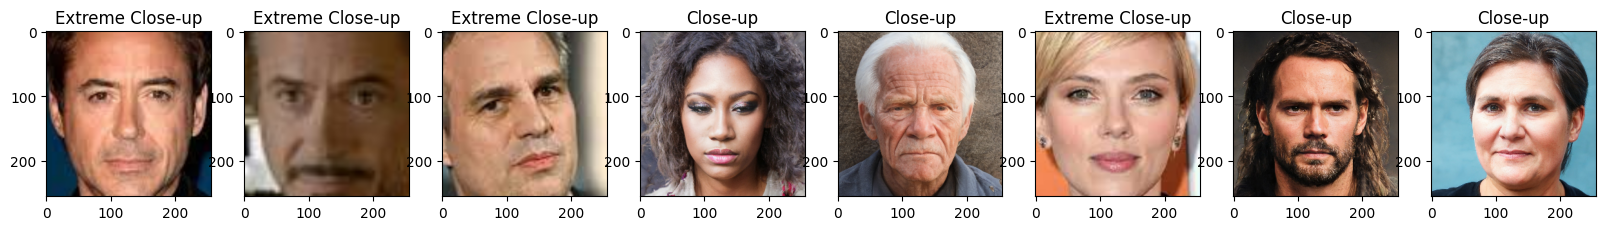

In [12]:
fig, ax = plt.subplots(ncols=8, figsize=(20,20))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(classes[batch[1][idx]])

In [13]:
data = data.map(lambda x,y: (x/255, y))

In [14]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [15]:
train_size

27

In [16]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [17]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

In [19]:
model = Sequential([
        Flatten(input_shape=(256,256,3)),
        Dense(3000, activation='relu'),
        Dense(1000, activation='relu'),
        Dense(len(classes), activation='softmax')    
    ])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 dense (Dense)               (None, 3000)              589827000 
                                                                 
 dense_1 (Dense)             (None, 1000)              3001000   
                                                                 
 dense_2 (Dense)             (None, 10)                10010     
                                                                 
Total params: 592838010 (2.21 GB)
Trainable params: 592838010 (2.21 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
model.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [23]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
27/27 [==============================] - 12s 427ms/step - loss: 6.9526 - accuracy: 0.4618 - val_loss: 1.0162 - val_accuracy: 0.6071
Epoch 2/20
27/27 [==============================] - 12s 422ms/step - loss: 1.0782 - accuracy: 0.6262 - val_loss: 0.8415 - val_accuracy: 0.5938
Epoch 3/20
27/27 [==============================] - 12s 414ms/step - loss: 0.9524 - accuracy: 0.6574 - val_loss: 0.9283 - val_accuracy: 0.6027
Epoch 4/20
27/27 [==============================] - 12s 438ms/step - loss: 0.7744 - accuracy: 0.7350 - val_loss: 0.5305 - val_accuracy: 0.8348
Epoch 5/20
27/27 [==============================] - 12s 424ms/step - loss: 0.8005 - accuracy: 0.7477 - val_loss: 0.5711 - val_accuracy: 0.8438
Epoch 6/20
27/27 [==============================] - 12s 428ms/step - loss: 0.5940 - accuracy: 0.8044 - val_loss: 0.3936 - val_accuracy: 0.8884
Epoch 7/20
27/27 [==============================] - 13s 462ms/step - loss: 0.4036 - accuracy: 0.8727 - val_loss: 0.3175 - val_accuracy: 0.9062

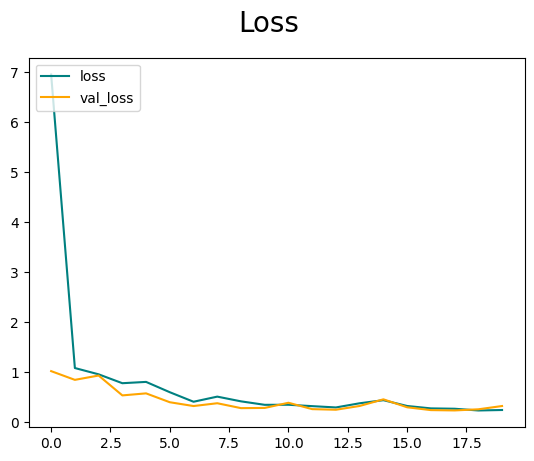

In [24]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

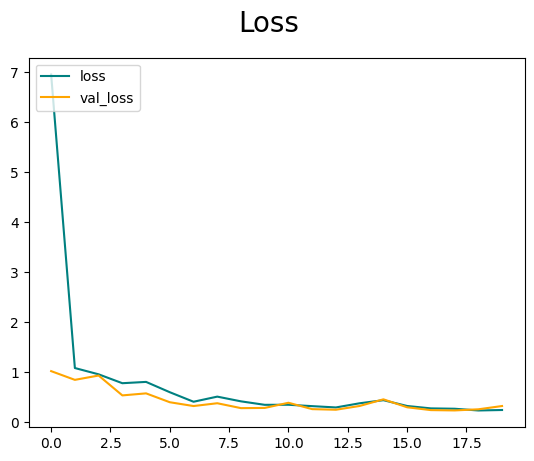

In [25]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Test

In [26]:
import cv2

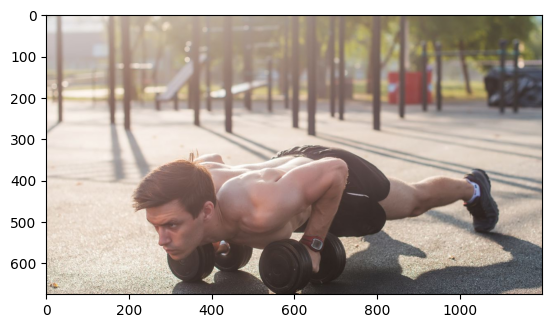

In [27]:
img = cv2.imread('tests/test14.jpg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

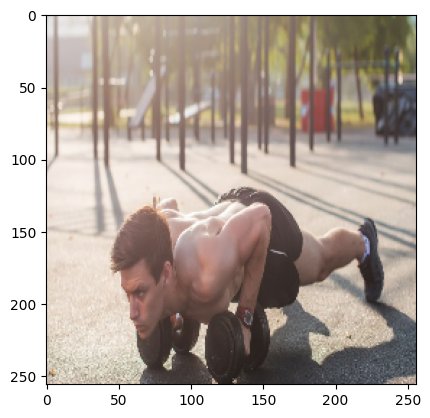

In [28]:
resize = tf.image.resize(cv2.cvtColor(img,cv2.COLOR_BGR2RGB), (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [29]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 113ms/step


In [30]:
yhat

array([[2.6291520e-03, 2.4989415e-03, 3.9839586e-03, 8.7814635e-01,
        4.0845737e-02, 5.5010892e-02, 7.0311357e-03, 5.4642283e-03,
        4.2313235e-03, 1.5826467e-04]], dtype=float32)

In [31]:
max(yhat)

array([2.6291520e-03, 2.4989415e-03, 3.9839586e-03, 8.7814635e-01,
       4.0845737e-02, 5.5010892e-02, 7.0311357e-03, 5.4642283e-03,
       4.2313235e-03, 1.5826467e-04], dtype=float32)

In [32]:
res = {}
for i in range(len(yhat[0])):
    #if(yhat[0][i] == max(yhat[0])):
      print(classes[i])
      print("Accuracy: {:.2f}% ".format(yhat[0][i] * 100))
      res[classes[i]] = yhat[0][i]

#result = sorted(res, key=lambda x:x[1])
#print(result)


Close-up
Accuracy: 0.26% 
Cowboy Shot
Accuracy: 0.25% 
Establishing Shot
Accuracy: 0.40% 
Extreme Close-up
Accuracy: 87.81% 
Extreme Wide Shot
Accuracy: 4.08% 
Full Shot
Accuracy: 5.50% 
Medium Close Up
Accuracy: 0.70% 
Medium Full Shot
Accuracy: 0.55% 
Medium Shot
Accuracy: 0.42% 
Wide Shot
Accuracy: 0.02% 


## Save Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','imageClass1.h5'))

In [ ]:
new_model = load_model(os.path.join('models','imageClass1.h5'))

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))